## Подключение библиотек и модулей

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Пути к файлам

In [2]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

## Функции и классы

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Ввод данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_PATH, sep = ',')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Оптимизация типов данных  для уменшения размера

In [7]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


In [9]:
train_df.dtypes

Id               category
DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### EDA (Визуализация)

In [10]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

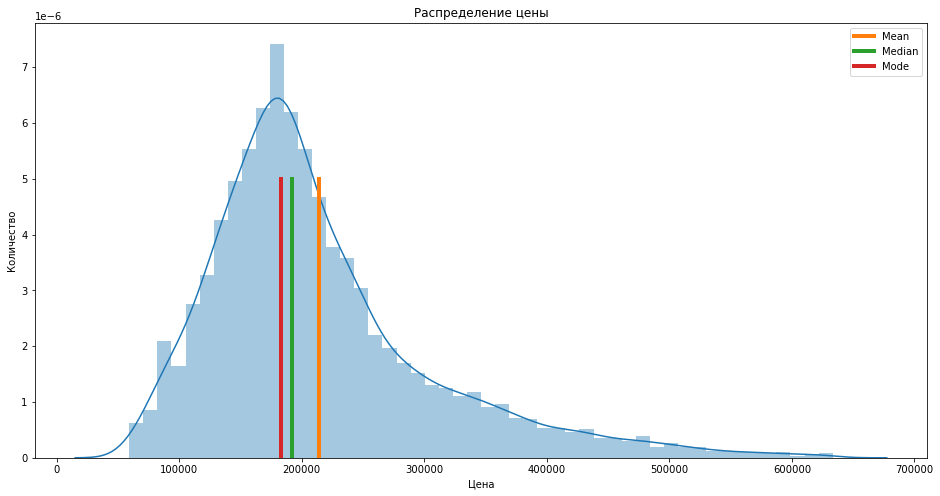

In [11]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.ylabel('Количество')
plt.xlabel('Цена')

plt.title('Распределение цены')
plt.legend()
plt.show()

In [12]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int8', 'int16', 'int32'])
train_df_num_features.drop('Price', axis=1, inplace=True)
train_df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,46,7960,6,350.0,3,11
9996,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,30,5562,0,NaN,0,5
9997,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,2,629,1,NaN,0,0
9998,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,30,5048,9,325.0,2,5


### Количественные признаки

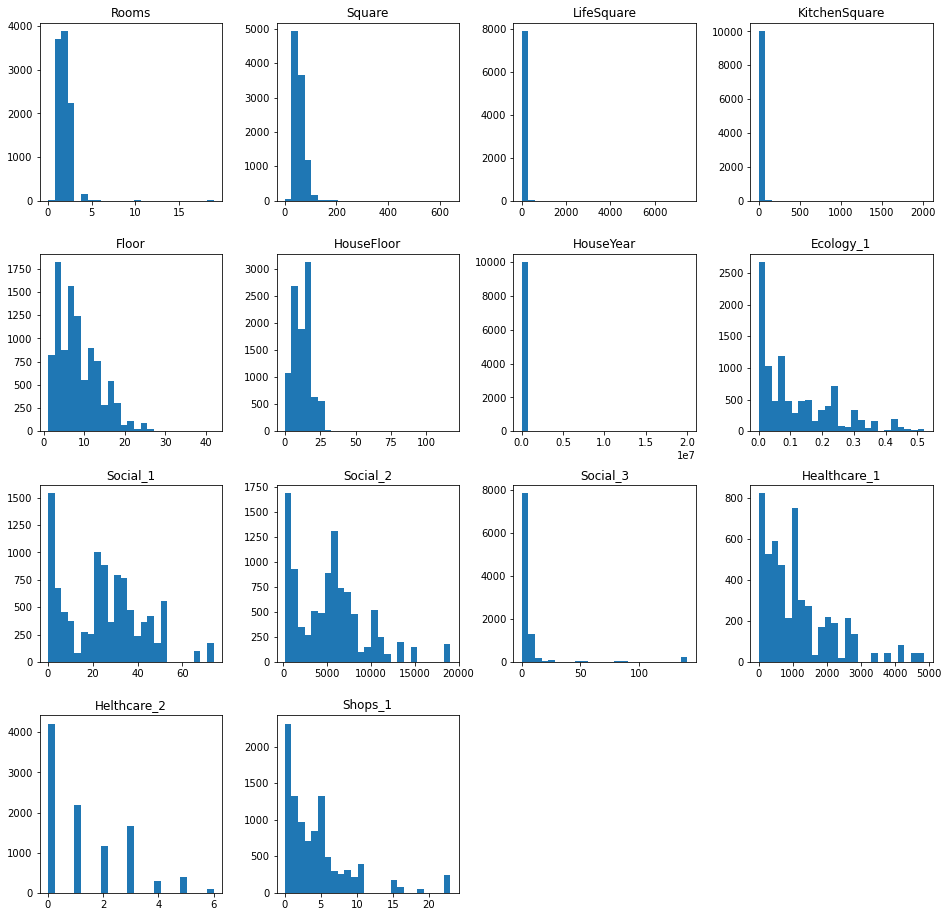

In [13]:
train_df_num_features.hist(figsize=(16,16), bins=25, grid=False);

In [14]:
train_df_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [15]:
min_quantile=train_df.quantile(q=0.025)
max_quantile=train_df.quantile(q=0.925)
medians = train_df.median()

#### Rooms

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [18]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df['Rooms'].isnull().sum()
train_df.loc[train_df['Rooms'] > max_quantile['Rooms'], 'Rooms'] = medians['Rooms']
train_df['Rooms'].value_counts()

#condition = (train_df['Rooms'] > min_quantile['Rooms']) | (train_df['Rooms'] < max_quantile['Rooms'])
#train_df.loc[condition, 'Rooms'] = medians['Rooms']

2.0    4052
1.0    3713
3.0    2235
Name: Rooms, dtype: int64

#### Floor, HouseFloor

In [19]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = medians['Floor']

#### HouseYear

In [20]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Square, LifeSquare, KitchenSquare

In [21]:
condition = (train_df['Square'] < min_quantile['Square']) | (train_df['Square'] > max_quantile['Square'])
train_df.loc[condition, 'Square'] = medians['Square']
condition = (train_df['LifeSquare'] < min_quantile['LifeSquare']) | (train_df['LifeSquare'] > max_quantile['LifeSquare'])
train_df.loc[condition, 'LifeSquare'] = medians['LifeSquare']
condition = (train_df['KitchenSquare'] < min_quantile['KitchenSquare']) | (train_df['KitchenSquare'] > max_quantile['KitchenSquare'])
train_df.loc[condition, 'KitchenSquare'] = medians['KitchenSquare']

#### Social_3

In [22]:
condition = (train_df['Social_3'] < min_quantile['Social_3']) | (train_df['Social_3'] > max_quantile['Social_3'])
train_df.loc[condition, 'Social_3'] = medians['Social_3']

#### Shops_1

In [23]:
train_df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

In [24]:
train_df['Shops_1'].describe()

count    10000.000000
mean         4.231300
std          4.806341
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         23.000000
Name: Shops_1, dtype: float64

In [25]:
condition = (train_df['Shops_1'] < min_quantile['Shops_1']) | (train_df['Shops_1'] > max_quantile['Shops_1'])
train_df.loc[condition, 'Shops_1'] = medians['Shops_1']

In [26]:
train_df['Shops_1'].describe()

count    10000.000000
mean         3.343800
std          3.083172
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         11.000000
Name: Shops_1, dtype: float64

### Категориальные признаки

In [27]:
cat_features_names = train_df.select_dtypes(include='category').columns.tolist()
cat_features_names

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [28]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [29]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [30]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [31]:
binary_to_numbers = {'A': 0, 'B': 1}
train_df['Ecology_2'] = train_df['Ecology_2'].map(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].map(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].map(binary_to_numbers)

### Обработка пропусков

In [32]:

train_df.fillna(medians, inplace=True)

### Генерация новых признаков

In [33]:
train_df['DistrictId']

0        35
1        41
2        53
3        58
4        99
       ... 
9995     32
9996     18
9997     27
9998     75
9999    128
Name: DistrictId, Length: 10000, dtype: category
Categories (205, object): ['0', '1', '10', '100', ..., '96', '97', '98', '99']

In [34]:
train_df['District_is_popular'] = 0
sales_offer_by_district = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'sales_offer_by_district'})
train_df = train_df.merge(sales_offer_by_district, how='left', on='DistrictId', sort=False)
train_df['sales_offer_by_district']

0        22
1        87
2       174
3       179
4        97
       ... 
9995     34
9996     51
9997    851
9998     66
9999     64
Name: sales_offer_by_district, Length: 10000, dtype: int64

In [35]:
train_df.loc[train_df['sales_offer_by_district'] > 200, 'District_is_popular'] = 1
train_df['District_is_popular'].value_counts()

0    6652
1    3348
Name: District_is_popular, dtype: int64

#### Удаление признаков

In [36]:
train_df.drop('Id', axis=1, inplace=True)
train_df.drop('DistrictId', axis=1, inplace=True)

### Построение функции для обработки данных

In [53]:
class DataPreproc:
    
    def __init__(self):
        self.medians = None
        self.min_quantile = None
        self.max_quantile = None
            
    def fit(self, df):
        self.min_quantile=df.quantile(q=0.025)
        self.max_quantile=df.quantile(q=0.925)
        self.medians = df.median()
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
                
    def transform(self, df):
        #заполнение пропусков
        df.fillna(self.medians, inplace=True)
        
        
        
        #работа с выбросами
        #rooms
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df['Rooms'].isnull().sum()
        df.loc[train_df['Rooms'] > self.max_quantile['Rooms'], 'Rooms'] = self.medians['Rooms']
        
        #Square, LifeSquare, KitchenSquare
        condition = (df['Square'] < self.min_quantile['Square']) | (df['Square'] > self.max_quantile['Square'])
        df.loc[condition, 'Square'] = self.medians['Square']
        condition = (df['LifeSquare'] < self.min_quantile['LifeSquare']) | (df['LifeSquare'] > self.max_quantile['LifeSquare'])
        df.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']
        condition = (df['KitchenSquare'] < self.min_quantile['KitchenSquare']) | (df['KitchenSquare'] > self.max_quantile['KitchenSquare'])
        df.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        
        #Floor, HouseFloor
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = self.medians['Floor']
        
        #HouseYear
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        #Social_3
        condition = (df['Social_3'] < self.min_quantile['Social_3']) | (df['Social_3'] > self.max_quantile['Social_3'])
        df.loc[condition, 'Social_3'] = self.medians['Social_3']
        
        #Shops_1
        condition = (df['Shops_1'] < self.min_quantile['Shops_1']) | (df['Shops_1'] > self.max_quantile['Shops_1'])
        df.loc[condition, 'Shops_1'] = self.medians['Shops_1']
        
        #Категориальные признаки
        
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        
        #Новые признаки
        df['District_is_popular'] = 0
        sales_offer_by_district = df['DistrictId'].value_counts().reset_index()\
        .rename(columns={'index':'DistrictId', 'DistrictId':'sales_offer_by_district'})
        df = df.merge(sales_offer_by_district, how='left', on='DistrictId', sort=False)
        df.loc[df['sales_offer_by_district'] > 200, 'District_is_popular'] = 1
        
        #удаляем признаки
        df.drop('Id', axis=1, inplace=True)
        df.drop('DistrictId', axis=1, inplace=True)
        

        
        return df

## Разбиение на train и test

In [38]:
train_df.columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'District_is_popular',
 'sales_offer_by_district']

In [39]:
feature_names = ['Rooms', 
                 'Square','LifeSquare','KitchenSquare',
                 'Floor','HouseFloor',
                 'HouseYear',
                 'Ecology_1','Ecology_2','Ecology_3',
                 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1','Helthcare_2',
                 'Shops_1', 'Shops_2',
                 'District_is_popular', 
                 'sales_offer_by_district'
                ]
target_name = 'Price'

In [40]:
X = train_df[feature_names]
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

## Построение модели

R2:	0.806
RMSE:	40957.957
MSE:	1677554249.637


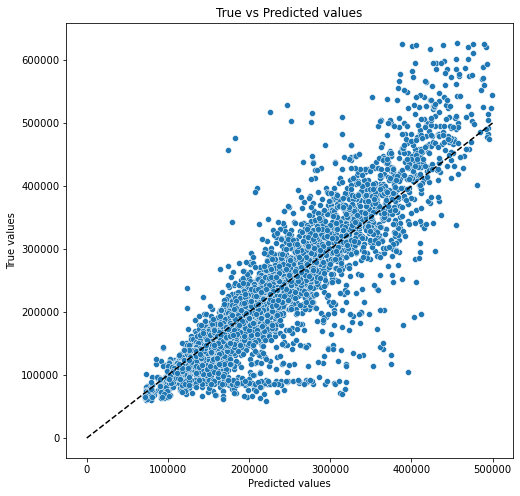

In [41]:
rf_model = RandomForestRegressor(criterion='mse',
                                     max_depth=20,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=400)
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.688
RMSE:	51840.919
MSE:	2687480895.861


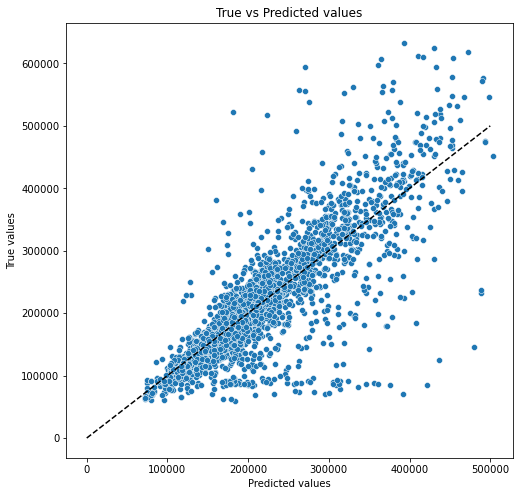

In [42]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

## Кроссвалидация

In [43]:
params = {'n_estimators':[50, 100, 200, 400, 500], 
          'max_depth':[5, 7, 10, 20]}

In [44]:
gs = GridSearchCV(rf_model, params, 
                  scoring='r2', 
                  cv=KFold(n_splits=5,
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(max_depth=20, min_samples_leaf=10,
                                             n_estimators=400,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 10, 20],
                         'n_estimators': [50, 100, 200, 400, 500]},
             scoring='r2')

In [45]:
gs.best_params_

{'max_depth': 20, 'n_estimators': 400}

## Оценка качества модели

In [46]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.301655
18,sales_offer_by_district,0.242414
0,Rooms,0.220969
2,LifeSquare,0.040462
7,Ecology_1,0.033672
11,Social_2,0.028611
12,Social_3,0.026453
6,HouseYear,0.025817
10,Social_1,0.019495
5,HouseFloor,0.015083


## Предсказание на тестовых данных

In [55]:
test = pd.read_csv(TEST_PATH, sep = ',')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [88]:
prep = DataPreproc()
prep.fit(test)
test_prep = prep.transform(test)
test_prep.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,District_is_popular,Price,sales_offer_by_district
0,2.0,49.882643,33.432782,6.0,6.0,14.0,1972,0.310199,NaN,NaN,11,2748,1.0,900.0,0,0.0,NaN,0,194261.836373,91
1,2.0,52.921340,32.925087,1.0,7.0,1.0,1977,0.075779,NaN,NaN,6,1437,3.0,900.0,0,2.0,NaN,0,268824.963744,61
2,1.0,52.921340,32.925087,6.0,2.0,5.0,1909,0.000000,NaN,NaN,30,7538,2.0,4702.0,5,5.0,NaN,0,198406.310433,2
3,2.0,52.921340,32.925087,9.0,22.0,22.0,2007,0.101872,NaN,NaN,23,4583,3.0,900.0,3,3.0,NaN,0,383065.211700,49
4,1.0,47.527111,32.925087,1.0,17.0,17.0,2017,0.072158,NaN,NaN,2,629,1.0,900.0,0,0.0,NaN,1,134145.379278,391


In [58]:
final_pred = rf_model.predict(test_prep)
final_pred

array([194261.83637347, 268824.96374423, 198406.31043293, ...,
       367741.7251575 , 230140.18061602, 277706.96222379])

In [89]:
test['Price'] = final_pred
test
result = test[['Id', 'Price']]
result.head()

,Id,Price
0,725,194261.836373
1,15856,268824.963744
2,5480,198406.310433
3,15664,383065.211700
4,14275,134145.379278


In [90]:
result.to_csv('KlimochkinMS_predictions.csv', index=False)